In [74]:
import os, sys, re
sys.path.append(os.path.dirname(os.getcwd()))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchcde
import h5py
from scipy.signal import find_peaks
import MulensModel as mm
import corner
from model.utils import getfsfb
from matplotlib.offsetbox import AnchoredText

from scipy.signal import medfilt
from PyAstronomy.pyasl import binningx0dt

from model.locator import Locator
from model.cde_mdn import CDE_MDN

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

In [75]:
gap = False
t_start = 8180
t_end = 8380
eventname = 'KB180800'

### feed estimator the parm from locator ###
t0, tE = [8280.102654, 40.558097]
# t0, tE = pred_t[0]

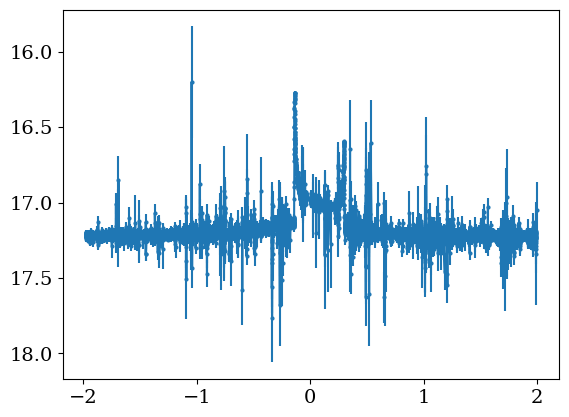

In [98]:
### preprocess ###
if gap:
    tel = pd.read_csv('KMT/%s/%s_aligned.csv'%(eventname, eventname), skiprows=0, usecols=[0, 2, 5, 6])
    tel = tel[(tel['Tel'] != 'KMTS01') & (tel['Tel'] != 'KMTS41')]
    x_orig = tel[['HJD', 'mag_aligned', 'e_mag_aligned']].to_numpy()
else:
    x_orig = np.loadtxt('KMT/%s/%s_aligned.csv'%(eventname, eventname), delimiter=',', skiprows=1, usecols=(2, 5, 6))
order = np.argsort(x_orig[:, 0])
x_orig = x_orig[order]
err = x_orig[:, -1]
x_orig = x_orig[:, :-1]


x_orig[:, 0] = (x_orig[:, 0] - t0)/tE
## -2 < t < 2
ind = (x_orig[:, 0] > -2) * (x_orig[:, 0] < 2)
mbase = x_orig[~ind, 1].mean()
x_orig = x_orig[ind]
err = err[ind]

fig, ax = plt.subplots(1, 1)
ax.errorbar(x_orig[:, 0], x_orig[:, 1], err, marker='o', markersize=2)
ax.invert_yaxis()
plt.show()


mbase:17.217872294997665


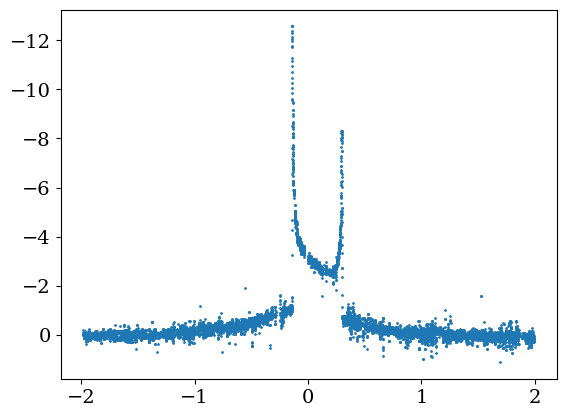

In [99]:
x = x_orig.copy()
## Perform a median filter on an N-dimensional array.
if gap:
    x[:, 1] = medfilt(x[:, 1], 7)
else:
    x[:, 1] = medfilt(x[:, 1], 5)

## err < 0.06
threshold = 0.06
ind = err < threshold
x = x[ind]
err = err[ind]

## align magnitude
print(f'mbase:{mbase}')
x[:, 1] = (x[:, 1] - mbase) / 0.075

fig, ax  = plt.subplots(1, 1)
ax.scatter(x[:, 0], x[:, 1], s=1)
ax.invert_yaxis()


In [100]:
print(len(x))

9871


[[-1.97859823e+00  8.36940003e-03  3.63618132e-03  1.70000000e+01]
 [-1.96359823e+00 -4.08439333e-02  6.15233979e-03  6.00000000e+00]
 [-1.95859823e+00 -2.26393330e-03  4.25531631e-03  1.20000000e+01]
 ...
 [ 1.98640177e+00  1.47036067e-01  3.86143541e-03  1.20000000e+01]
 [ 1.99140177e+00  1.89702733e-01  7.51675264e-03  8.00000000e+00]
 [ 1.99640177e+00  1.32756067e-01  5.50480000e-02  1.00000000e+00]]
684


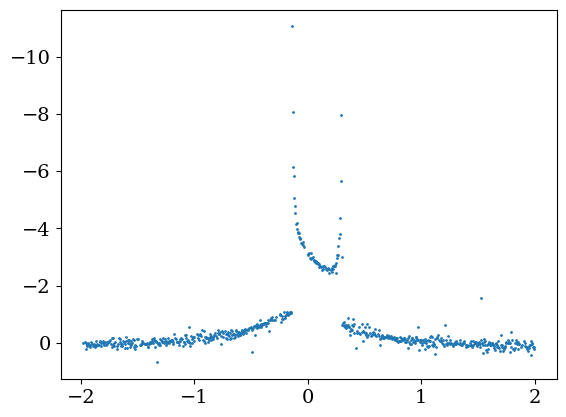

In [101]:
### bin data ###
x_binned, dt = binningx0dt(x[:, 0], x[:, 1], err, dt=0.005, yvalFunc=np.median)
print(x_binned)
fig, ax  = plt.subplots(1, 1)
ax.scatter(x_binned[:, 0], x_binned[:, 1], s=1)
ax.invert_yaxis()
print(len(x_binned))


In [102]:
x = x_binned[:, :2]
err = x_binned[:, 2]/0.2

In [103]:
### preprocess data with the log-signature transform
data = torch.tensor(x.reshape(1, *x.shape))
# depth = 3; window_length = 4
depth = 3; window_length = 8
data = torchcde.logsig_windows(data, depth, window_length=window_length)


In [104]:
### predict ###
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(data)
checkpt = torch.load('experiments/estimator/estimator_l32nG12diag.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

output_dim = 5
input_dim = data.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [105]:
### predict with CDE ###
with torch.no_grad():
    pi, normal = model(train_coeffs.float().to(device))
n = int(1e6)

pi_ = pi.probs.cpu(); loc_ = normal.loc.cpu(); scale_ = normal.scale.cpu()
pi_ = torch.tile(pi_, (n, 1)); loc_ = torch.tile(loc_, (n, 1, 1)); scale_ = torch.tile(scale_, (n, 1, 1))
normal_dist = torch.distributions.Normal(loc_, scale_)
pi_dist = torch.distributions.OneHotCategorical(probs=pi_)
sample = model.sample(pi_dist, normal_dist).numpy()


In [106]:
print(sample.shape)

(1000000, 5)


In [126]:
test_p = [[0.1, -3, -0.25, -0.06, 1.46, 0],
        [0.1, -3, -0.25, 0.2, 1.46, 0]]
fs, fb = getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *test_p[0][:-1])[1:3]
test_p[0][-1] = np.log10(fs / (fs + fb))
fs, fb = getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *test_p[1][:-1])[1:3]
test_p[1][-1] = np.log10(fs / (fs + fb))
truths_full = np.array(test_p)
truths = np.delete(truths_full, 1, axis=-1)
print(truths)

[[ 0.1        -0.25       -0.06        1.46       -1.39825739]
 [ 0.1        -0.25        0.2         1.46       -0.73525297]]


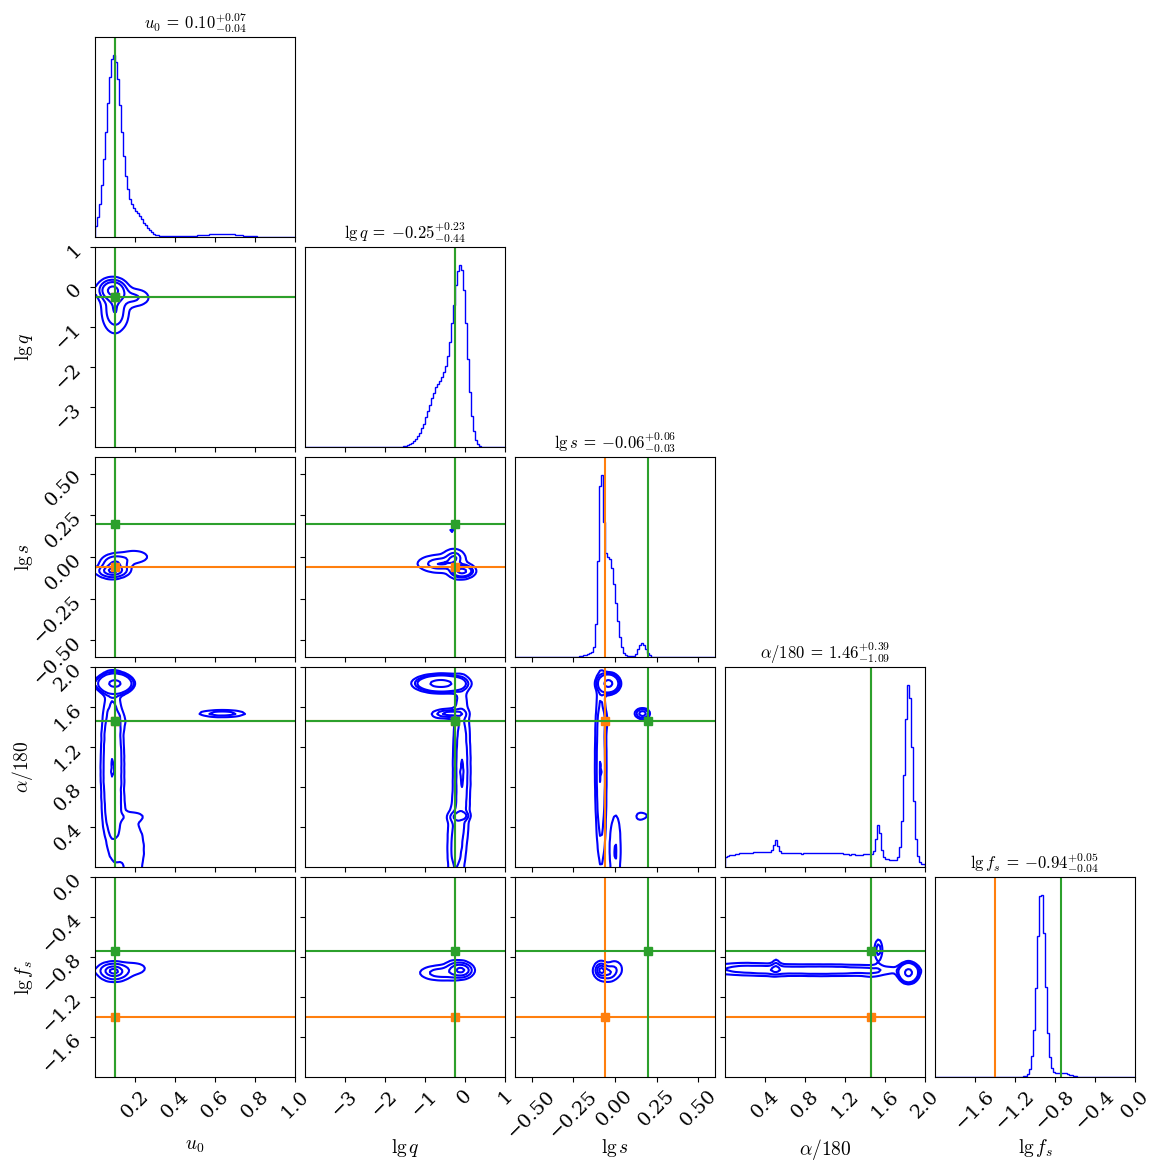

In [127]:
range_p = [(0, 1), (-4, 1), (-0.6, 0.6), (0, 2), (-2, 0)]
# range_p = None
sigma_level = 1-np.exp(-0.5)
fig = corner.corner(sample, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            smooth=1,
            bins=100,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 12},
            truths=truths[0], truth_color='C1', 
            fill_contours=False, color='blue', no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            )
corner.overplot_lines(fig, truths[1], color="C2")
corner.overplot_points(fig, truths[1][None], marker="s", color="C2")
plt.show()

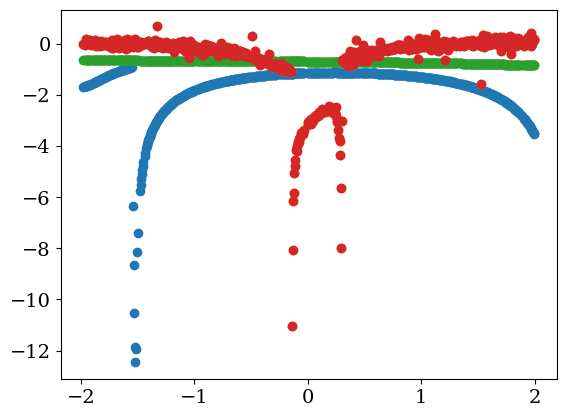

In [162]:

if gap:
    tel = pd.read_csv('KMT/%s/%s_aligned.csv'%(eventname, eventname), skiprows=0, usecols=[0, 2, 5, 6])
    tel = tel[(tel['Tel'] != 'KMTS01') & (tel['Tel'] != 'KMTS41')]
    x_orig = tel[['HJD', 'mag_aligned', 'e_mag_aligned']].to_numpy()
else:
    x_orig = np.loadtxt('KMT/%s/%s_aligned.csv'%(eventname, eventname), delimiter=',', skiprows=1, usecols=(2, 5, 6))
order = np.argsort(x_orig[:, 0])
x_orig = x_orig[order]
err = x_orig[:, -1]
x_orig = x_orig[:, :-1]

x = x_orig.copy()

from MulensModel.binarylens import BinaryLens
for i in range(2):
    param = truths[i]
    u0 = param[0]
    m_p = 1 / (pow(10, param[1]) + 1)
    m_s = pow(10, param[1]) / (pow(10, param[1]) + 1)
    s = pow(10, param[2])
    alpha = param[3]*np.pi
    blens = BinaryLens(m_p, m_s, s)

    A = np.zeros((2, 2))
    A[0, 0] = np.cos(alpha)
    A[0, 1] = -np.sin(alpha)
    A[1, 1] = np.sin(alpha)
    A[1, 1] = np.cos(alpha)
    lc = []
    for j in range(len(x)):
        d = np.ones(2)
        d[0] = (x[j,0] - 0)/1
        d[1] = u0
        ux, uy = np.dot(A, d) 
        lc.append(blens.vbbl_magnification(ux, uy, pow(10, -3)))
    lc = np.array(lc)
    plt.scatter(x[:, 0], -lc/5)
    plt.scatter(x[:, 0], x[:, 1])
